In [1]:
import numpy as np
from TMDP import TMDP
from River_swim import River

from algorithms import *
from PG_algorithms import *
from model_functions import *
import gym
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import functional as F
from PolicyPi import PolicyPi
#np.set_printoptions(precision=4)
import math
from utils import *
from ActorCritic import *
nS = 50
nA = 2
seed = get_current_seed()
seed = 44697628841978080856580175700798794719
gamma = .9
mu = np.ones(nS) * 1/nS
river = River(nS, mu, small=5, large=1000, seed=seed)
tau = 1.
xi = np.ones(nS) * 1/nS
tmdp = TMDP(river, xi, tau=tau, gamma=gamma, seed=seed)


Current seed for result reproducibility: 296318469482554426941273113700327819670


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
actor_func = ActorNet(nS, nA).to(device)
value_func = ValueNet(nS).to(device)
q_func = QNet(nS, nA).to(device)

In [3]:
tmdp.reset()
tmdp.update_tau(.5)
pol_opt = torch.optim.AdamW(actor_func.parameters(), lr=1e-2)
val_opt = torch.optim.AdamW(value_func.parameters(), lr=1e-2)
q_opt = torch.optim.AdamW(q_func.parameters(), lr=1e-3)

cur_res = curriculum_ActorCritic(tmdp, actor_func, value_func, q_func, pol_opt, val_opt, q_opt, alpha=.02, episodes=3000000, batch_nS=1, biased=False)


[(0.0, 0.4995), (1.0, 0.60322)]
[3.867360325009495e-06, -0.5443204899063349]
Updating the policy with alpha_star:  0.0 tau_star:  0.4995
Running episode 3 reward 5.0
[(0.00931, 0.4995), (0.0, 0.49861), (1.0, 0.57066)]
[7.016147689527742e-06, 2.4142857786428788e-05, -0.5416874241962053]
Updating the policy with alpha_star:  0.0 tau_star:  0.49861
Running episode 89 reward 5.0
[(0.01172, 0.49861), (0.0, 0.49786), (1.0, 0.55087)]
[9.367269807286036e-06, 2.503385737583169e-05, -0.43613521744757744]
Updating the policy with alpha_star:  0.0 tau_star:  0.49786
Running episode 91 reward 5.0
[(0.00102, 0.49786), (0.0, 0.49711), (1.0, 0.53723)]
[5.786510609676941e-08, 3.3088174020756666e-05, -0.331662104035603]
Updating the policy with alpha_star:  0.0 tau_star:  0.49711
Running episode 106 reward 5.0
[(0.01211, 0.49711), (0.0, 0.49632), (1.0, 0.52758)]
[6.35665422447345e-06, 4.569828618083941e-05, -0.24722697934516763]
Updating the policy with alpha_star:  0.0 tau_star:  0.49632
Running episod

In [4]:
res = bellman_optimal_q(tmdp.env.P_mat, tmdp.env.reward, tmdp.gamma)
Q = res["Q"]

d = compute_d_from_tau(tmdp.env.mu, tmdp.env.P_mat, tmdp.xi, get_policy(Q), tmdp.gamma, 0.)
d_curr = compute_d_from_tau(tmdp.env.mu, tmdp.P_mat_tau, tmdp.xi, get_policy(actor_func.get_probabilities()), tmdp.gamma, 0.)

print(get_policy(Q) - get_policy(actor_func.get_probabilities()))

r_s_a = compute_r_s_a(tmdp.env.P_mat, tmdp.env.reward)

j_opt = compute_j(r_s_a, get_policy(Q), d, tmdp.gamma)
j_curr = compute_j(r_s_a, get_policy(actor_func.get_probabilities()), d_curr, tmdp.gamma)
print("optimal performance: ",j_opt, "curriculum performance: ",j_curr)
print(actor_func.get_probabilities())

[[ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 1. -1.]
 [ 0.  0.]
 [ 0.  0.]
 [ 1. -1.]
 [ 1. -1.]
 [ 1. -1.]
 [ 1. -1.]
 [ 1. -1.]
 [ 1. -1.]
 [ 0.  0.]
 [ 0.  0.]
 [ 1. -1.]
 [ 1. -1.]
 [-1.  1.]
 [ 0.  0.]
 [-1.  1.]
 [-1.  1.]
 [ 0.  0.]
 [ 0.  0.]
 [-1.  1.]
 [ 0.  0.]
 [-1.  1.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]
 [ 0.  0.]]
optimal performance:  70.66229588024339 curriculum performance:  67.06734880351735
[[1.00000000e+00 1.33684330e-09]
 [1.00000000e+00 4.79300244e-09]
 [1.00000000e+00 6.12026074e-09]
 [1.00000000e+00 2.13174745e-09]
 [1.00000000e+00 5.02630115e-09]
 [1.00000000e+00 7.22153226e-09]
 [1.00000000e+00 2.50637555e-09]
 [1.00000000e+00 1.57454423e-08]
 [1.00000000e+00 1.32508262e-08]
 [1.00000000e+00 9.44248768e-09]
 [1.00000000e+00 3.00290033e-08]
 [1

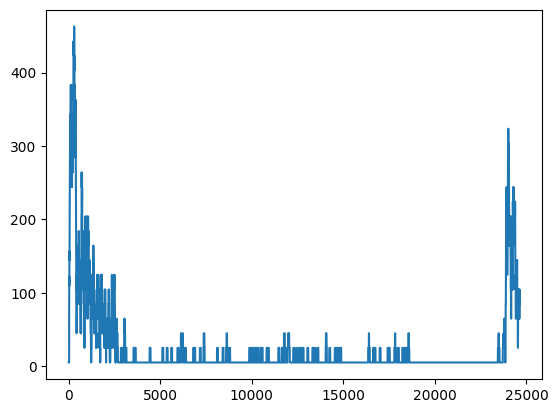

In [5]:
import matplotlib.pyplot as plt
reward_records = cur_res["reward_records"]
# Generate recent 50 interval average
average_reward = []
for idx in range(len(reward_records)):
    avg_list = np.empty(shape=(1,), dtype=int)
    if idx < 50:
        avg_list = reward_records[:idx+1]
    else:
        avg_list = reward_records[idx-49:idx+1]
    average_reward.append(np.average(avg_list))
# Plot
#plt.plot(reward_records)
plt.plot(average_reward)


In [6]:
s = torch.tensor([2, 1], dtype=torch.long).to(device)
print(s)

tensor([2, 1], device='cuda:0')
